# Topic modeling paso a paso: los temas de la pandemia

Esta notebook muestra las etapas de una experiencia de modelización de tópicos con un corpus de tweets sobre la pandemia de coronavirus. Aquí explicamos cómo:

- preprocesar los datos
- entrenar modelos con LDA
- generar visualizaciones de los resultados

Autora: Nidia Hernández, CAICYT-CONICET, nidiahernandez@conicet.gov.ar

## Requerimientos

Primero, nos aseguramos de instalar las librerías necesarias y otros requerimientos.

In [47]:
#! pip install requirements.txt
#! python -m nltk.downloader stopwords

Importamos las librerías y las funciones que vamos a usar para el procesamiento:

In [48]:
from os.path import isfile
from os import makedirs
import re

from detectar_topicos import * # Importa las funciones del script detectar_topicos.py

from nltk.tokenize import RegexpTokenizer

from tqdm import tqdm

import gensim
from gensim import corpora
from gensim.models import Phrases
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

import pandas as pd
import matplotlib.pyplot as plt
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Carga del corpus

Usamos https://covid.dh.miami.edu/get/ para obtener una colección de tweets por fecha. Los tweets son descargados en formato txt, un tweet por línea. 

Aquí vamos a trabajar con los tweets sobre el covid19 de la última semana de octubre 2020 en Argentina.

In [49]:
corpus_path = 'dhcovid_2020-11-06_es_ar.txt'
corpus_label = corpus_path.replace('.txt', '')

with open(corpus_path, 'r') as fi:
    tweets = fi.read()
    tweets = set(tweets.split('\n') ) # elimina duplicados
    tweets = list(list(tweets))

print(f'Hay {len(tweets)} tweets en la colección')

Hay 2142 tweets en la colección


Veamos los diez primeros tweets de esta colección:

In [50]:
#tweets[:10]

Hay muchos tokens irrelevantes para nuestro objetivo de detección de tópicos: 'URL', '@user', números, palabras vacías de contenido informativo, etc.

## Preprocessing

Es habitual mejorar la calidad de los datos de entrada del topic modeling realizando diversos tipos de preprocesamiento. Los más rápidos y sencillos son eliminar tokens poco pertinentes. Otros pueden ser computacionalmente más costosos pero mejoran notablemente la legibilidad de los resultados. En esta experiencia, realizaremos un pretratamiento standard: filtrar tokens, generar bigramas y marcar Named Entities.

Creamos una etiqueta para identificar los modelos de acuerdo al pretratamiento que vamos a realizar:

In [51]:
model_label = '2gram_ner_LDA'

En primer lugar, eliminamos las transliteraciones de emojis usando la función `remove_emojis`:

In [52]:
tweets = [remove_emojis(tweet).strip() for tweet in tweets]
tweets = [tweet for tweet in tweets if tweet]
tweets = [tweet.split() for tweet in tweets]

Luego, eliminamos las palabras gramaticales ('la', 'que', 'de', etc) ya que son muy frecuentes pero no aportan información temática significativa. En el ámbito del _text processing_ estas palabras son conocidas como _stopwords_. Cargamos una lista genérica de _stopwords_ del español y le añadimos tokens particulares de nuestro corpus:

In [53]:
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
stop_words_extra = ['@user', '#covid19', '#covid','#coronavirus','URL','xq','pq', 'q', 'd', 'x', 'e', 'k', 'l', 're','ja', 'jaja'
                    'si', 'mas','da','dia', 'hoy', 'año', 'aca', 'ahi', 'aqui', 'vez', 'tras', 'traves', 'bueno']
stop_words = stop_words+stop_words_extra

print(f"[{corpus_label}-{model_label}] Filtrando stopwords")
tweets_filtrados = [[token for token in texto if token not in stop_words] for texto in tweets]

[dhcovid_2020-11-06_es_ar-2gram_ner_LDA] Filtrando stopwords


Nos interesa que conservar expresiones como "nuevo caso" o "vacuna rusa" porque ayudan notablemente a la lectura de resultados frente a las mismas palabras por separado. Esto lo logramos generando los bigramas de los tweets y conservando los que aparecen al menos 20 veces en la colección:

In [54]:
print(f"[{corpus_label}-{model_label}] Generando bigramas")
bigram = Phrases(tweets, min_count=15)

tweets_bigrams = tweets_filtrados.copy()
for idx in tqdm(range(len(tweets_filtrados))):
    for token in bigram[tweets_filtrados[idx]]:
        if '_' in token:
            tweets_bigrams[idx].append(token)

  0%|          | 0/2142 [00:00<?, ?it/s]

[dhcovid_2020-11-06_es_ar-2gram_ner_LDA] Generando bigramas


100%|██████████| 2142/2142 [00:00<00:00, 39419.60it/s]


Filtramos los números después de generar los bigramas para conservar expresiones como '24_horas'.

In [55]:
tweets_bigrams_filt = [[token for token in texto if not token.isnumeric()] for texto in tweets_bigrams]

Otro procesamiento que permite lograr resultados más claros para la lectura humana es la identificación de Named Entities. Esta técnica nos permite detectar expresiones como 'hospital ramos mejia' para marcarlas así 'hospital_ramos_mejia'.

Previamente, usamos Spacy para detectar automáticamente las Named Entities de esta colección y las volcamos en una lista que revisamos manualmente para eliminar falsos positivos.

In [56]:
# import spacy
# spacy_nlp = spacy.load('es_core_news_lg')
# tweets_spacy = [spacy_nlp(' '.join(tweet), disable=["tagger", "parser"]) for tweet in tqdm(tweets_bigrams_filt)]

# with open(f'{corpus_label}_NE.lst', 'w') as fi:
#     for tweet in tweets_spacy:
#         for entity in tweet.ents:
#             entity_words = str(entity).split()
#             if len(entity_words) > 1:
#                 fi.write(f'{" ".join(entity_words)}\n')

In [57]:
print(f"[{corpus_label}-{model_label}] Identificando Named Entities")
with open(f'dhcovid_es_ar_NE.lst', 'r') as fi: # lista de NE revisada manualemente
    entidades_curadas = fi.read().split('\n')

tweets_ner = []
for texto in tqdm(tweets_bigrams_filt):
    texto = ' '.join(texto)
    for entity in entidades_curadas:
        entity_merged = '_'.join(entity.split())
        texto = texto.replace(entity, entity_merged)
    tweets_ner.append(texto.split())
    

  0%|          | 0/2142 [00:00<?, ?it/s]

[dhcovid_2020-11-06_es_ar-2gram_ner_LDA] Identificando Named Entities


100%|██████████| 2142/2142 [00:01<00:00, 1315.66it/s]


Todas estas manipulaciones del corpus pueden ser costosas, por eso conviene guardar una copia del resultado:

In [58]:
processed_tweets_path = corpus_path.replace(".txt", ".processed-tweets.json")

print(f"[{corpus_label}] Guardando copia de tweets procesados")
dump_processed_tweets_as_json(tweets_ner, processed_tweets_path)

[dhcovid_2020-11-06_es_ar] Guardando copia de tweets procesados


## Entrenamiento

Una vez que los datos de entrada fueron adaptados, podemos proceder al aprendizaje no supervisado de tópicos. Como los tópicos emergen automáticamente de los datos, no podemos saber de antemano cuántos serán. El parámetro `topic_numbers_to_try` permite configurar el rango de tópicos a entrenar.

En este paso, también podemos refinar el corpus de entranda. El parámetro `filter_extremes` permite excluir palabras de frecuencia muy baja o demasiado alta (ver la función `make_dictionary_and_matrix` en `detectar_topicos.py`).

⚠️ El aprendizaje puede llevar muchas horas si el corpus es grande.

In [59]:
print(f"[{corpus_label}-{model_label}] Unsupervised learning")
models_dir='./dhcovid_tweets_models'

models = train_several_LDA_models(
    documentos=tweets_ner,
    topic_numbers_to_try=range(3, 51),
    corpus_label=corpus_label,
    model_label=model_label,
    models_dir=models_dir,
    overwrite=True,
    filter_extremes=True,
)

[dhcovid_2020-11-06_es_ar-2gram_ner_LDA] Unsupervised learning
Training LDA model with 3 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics03
Training LDA model with 4 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics04
Training LDA model with 5 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics05
Training LDA model with 6 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics06
Training LDA model with 7 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics07
Training LDA model with 8 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics08
Training LDA model with 9 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics09
Training LDA model with 10 topics
Saving in ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA-ntopics10
Training

¿Cómo saber cuál es el modelo con el número óptimo de tópicos?

## Evaluación automática

En el paso anterior, entrenamos modelos para un amplio rango de tópicos. ¿Cómo saber cuál es el que mejor representa las temáticas que se tratan en nuestro corpus de tweets de Argentina de la última semana de octubre 2020 sobre el covid19?

Una manera de encontrar _automáticamente_ el modelo con el mejor número de tópicos es usar un score de coherencia. Existen varias medidas que permiten evaluar la coherencia de los modelos generados. En esta notebook vamos a usar _cv_.

Calculating model coherence: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


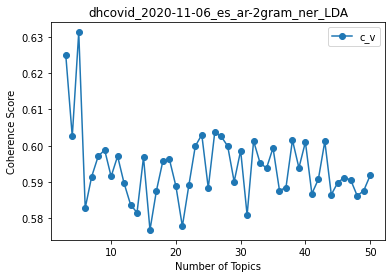

El modelo más coherente tiene 5 tópicos y recibió un score de c_v de 0.63


In [60]:
scores = calculate_topic_coherence(models, tweets_ner, measures=["c_v"], filter_extremes=True)
scores.to_csv(f'{models_dir}/{corpus_label}-{model_label}-coherence.csv')
plot_cv(scores, corpus_label, model_label, models_dir)

ntopics_with_top_cv_score = scores.set_index("ntopics").c_v.idxmax()
cv_score = round(scores.c_v.max(), 2)

print(f"El modelo más coherente tiene {ntopics_with_top_cv_score} tópicos y recibió un score de c_v de {cv_score}")

El score automático nos permite descartar rápidamente varios modelos, pero es necesario encontrar un compromiso entre el valor del score y un número de tópicos razonable para la evaluación cualitativa. En otras palabras, si tenemos, por ejemplo, un modelo con _cv_ de 0.7 y 150 tópicos puede ser poco práctico para un análisis humano, es preferible un modelo con un _cv_ menor y un número de tópicos más accesible para la lectura humana.

## Análisis de resultados

Cada modelo tiene una cantidad de tópicos posibles. A su vez, cada tópico está integrado por las palabras más probables para ese tópico y la probabilidad asociada. Para visualizar toda esta información, construimos una tabla con los tópicos, las palabras y las probabilidades para el modelo que recibió el mejor scoring.

In [61]:
best_model = models[ntopics_with_top_cv_score]
tabla = make_table_all_topics(best_model, model_label, corpus_label)
tabla.to_csv(f'{models_dir}/{corpus_label}-{model_label}-topics.csv')
tabla.head(10)

,model_name,topic_id,word_ranking,word,word_proba
0,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,1,dio,0.010840
1,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,2,contacto,0.010040
2,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,3,pa,0.008868
3,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,4,pesar,0.008728
4,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,5,uruguay,0.008621
5,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,6,minutos,0.008441
6,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,7,alta,0.008166
7,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,8,contagiados,0.007267
8,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,9,cura,0.007165
9,dhcovid_2020-11-06_es_ar-2gram_ner_LDA,1,10,aislado,0.006952


Ahora, para cada tópico, visualizamos las palabras que lo componen:

In [62]:
topic_total = tabla.topic_id.unique()
for topic_id in topic_total:
    topic = tabla.query("topic_id == @topic_id")
    print(f'Tópico {topic_id}: ', " | ".join(topic.word))

Tópico 1:  dio | contacto | pa | pesar | uruguay | minutos | alta | contagiados | cura | aislado | dio_positivo | elecciones | jornada | ultimo | detectaron
Tópico 2:  ir | muertes | jueves | viernes | mes | santa_fe | rosario | salir | total | informe | noche | atras | viene | inmune | fernandez
Tópico 3:  van | quiero | nueva | mierda | rusa | vacuna_rusa | voy | amba | pais | dicen | presidente | vivir | vida | vacunas | puta
Tópico 4:  argentina | fallecio | pacientes | mundo | ibuprofeno | vamos | barbijo | horas | aun | ultimas | tratar | paciente | dale | saber | gran
Tópico 5:  aspo | nuevo | ver | semanas | caso | dispo | orto | activos | millones | seguro | ganas | agarrar | atencion | contagia | mata


Podemos generar una visualización interactiva con más información donde podemos observar fácilmente cantidad de tópicos, distancia, peso y palabras de cada tópico:

In [63]:
plot_LDA_topics(best_model, tweets_ner, output_path=f'{models_dir}/{corpus_label}-{model_label}.html', filter_extremes=True)

Saving topic visualization to: ./dhcovid_tweets_models/dhcovid_2020-11-06_es_ar-2gram_ner_LDA.html


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.191212  0.201864       1        1  25.138760
3      0.147809  0.047402       2        1  20.374561
0      0.151313  0.050564       3        1  20.164467
1      0.029387 -0.103335       4        1  18.349558
4     -0.137296 -0.196496       5        1  15.972653, topic_info=        Term       Freq      Total Category  logprob  loglift
996     aspo  31.000000  31.000000  Default  30.0000  30.0000
802   quiero  40.000000  40.000000  Default  29.0000  29.0000
636      van  57.000000  57.000000  Default  28.0000  28.0000
98     nuevo  43.000000  43.000000  Default  27.0000  27.0000
131      dio  32.000000  32.000000  Default  26.0000  26.0000
...      ...        ...        ...      ...      ...      ...
1266    mira  14.197158  27.632893   Topic5  -5.0984   1.1683
753   ciudad  12.048079  19.358204   Topic5  -5.2625   1.3601
1286  clases  13.129395  34.115032   Topic5  -5.1765   0.8794
1340    amba  12.957816  41.201668   Topic5  -5.1897   0.6775
562    salir  10.838799  31.217779   Topic5  -5.3683   0.7764

[262 rows x 6 columns], token_table=      Topic      Freq                    Term
term                                         
1109      3  0.962226        #ahoramontevideo
958       3  0.908062         #elecciones2020
367       3  0.915360  #noscuidamosentretodos
1112      3  0.945613        #quedateentucasa
1551      3  0.977907                  #river
...     ...       ...                     ...
107       1  0.329475                 viernes
107       4  0.658950                 viernes
322       1  0.974889                   vivir
323       1  0.640642                     voy
323       4  0.343201                     voy

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2, 5])